In [14]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, SobolIndices, KrigingModel, RandomForestModel
from shapley.tests import AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results
from shapley.plots import plot_correlation_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0., 1.]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
dim = 3
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]

In [16]:
n_corr = 20
corrs = np.linspace(-0.999, 0.999, n_corr)

No = 100
Ni = 50
Nv = 5000
n_perms = None
c_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = Nv + No * Ni * c_perms * (dim - 1)
n_sample = int(max_budget / (dim*4))
n_sample = 5400
print('Max budget:', max_budget)

estimator_sobol_full_ind = 'sobolmara'
n_boot = 300

('Max budget:', 65000)


In [21]:
use_meta_model = False
n_realization = 1
if use_meta_model:
    ot.RandomGenerator.SetSeed(0)
    np.random.seed(0)
    model_budget = 10
    n_realization = 200
    basis = 'linear'
    kernel = 'matern'
    library = 'gpflow'
    sampling = 'lhs'
    model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
    model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
    model_gp.build(library=library, kernel=kernel, basis_type=basis)
    
    n_sample_cv = 10000
    score_q2_cv = model_gp.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
    print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

In [70]:
n_realization = 500
rf_indices = np.zeros((n_corr, dim, n_realization))
for i, corr in enumerate(corrs):
    theta = [0., 0., corr]
    model.copula_parameters = theta
    model_rf = RandomForestModel(model, input_distribution=model.input_distribution)
    model_rf.generate_sample(n_sample=5000, sampling='monte-carlo', sampling_type='classic')
    model_rf.build(n_realization)
    forest = model_rf.reg_rf
    rf_indices[i] = np.asarray([tree.feature_importances_ for tree in forest.estimators_]).T

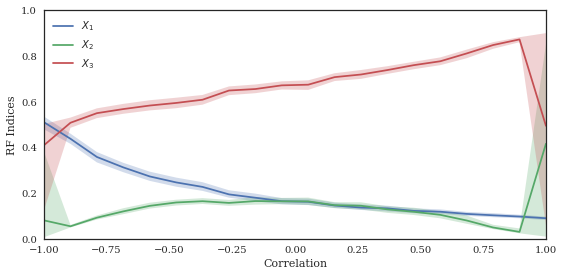

In [71]:
fig, ax = plt.subplots(figsize=(8, 4))
alpha = 0.99
for i in range(dim):
    ind = rf_indices[:, i]
    ax.plot(corrs, ind.mean(axis=1), label="$X_%d$" % (i+1))
    quantiles = np.percentile(ind, [1, 99], axis=1)
    ax.fill_between(corrs, quantiles[0, :], quantiles[1, :], alpha=0.25)
    
ax.legend(loc=0)
ax.set_ylim(ylim)
ax.set_xlim(corrs[0], corrs[-1])
ax.set_xlabel('Correlation')
ax.set_ylabel('RF Indices')
fig.tight_layout()

In [ ]:
result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

true_result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }


for corr in corrs:
    print('Corr:', corr)
    theta = [0., 0., corr]
    model.copula_parameters = theta
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
        
    #Sobol Full and Ind
    if use_meta_model:
        sobol = SobolKrigingIndices(model.input_distribution)
        sobol.build_uncorrelated_mc_sample(model_gp, n_sample, n_realization=n_realization)
    else:
        sobol = SobolIndices(model.input_distribution)
        sobol.build_uncorrelated_mc_sample(model, n_sample)
        
    sobol_results_full = sobol.compute_full_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    sobol_results_ind = sobol.compute_ind_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    
    # Shapley
    if use_meta_model:
        shapley = ShapleyKrigingIndices(model.input_distribution)
        shapley.build_mc_sample(model=meta_model, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)
    else:
        shapley = ShapleyIndices(model.input_distribution)
        shapley.build_mc_sample(model=model, n_perms=None, Nv=Nv, No=No, Ni=Ni)
    
    shapley_results = shapley.compute_indices(n_boot=n_boot)
    
    # Save results
    result_indices['Shapley'].append(shapley_results.full_shapley_indices.ravel())
    result_indices['First Sobol'].append(shapley_results.full_first_indices.ravel())
    result_indices['Total Sobol'].append(shapley_results.full_total_indices.ravel())
    result_indices['First full Sobol'].append(sobol_results_full.full_first_indices.ravel())
    result_indices['Total full Sobol'].append(sobol_results_full.full_total_indices.ravel())    
    result_indices['First ind Sobol'].append(sobol_results_ind.full_first_indices.ravel())
    result_indices['Total ind Sobol'].append(sobol_results_ind.full_total_indices.ravel())
    
    # Save true results
    true_result_indices['Shapley'].append(model.shapley_indices)
    true_result_indices['First Sobol'].append(model.first_order_sobol_indices)
    true_result_indices['Total Sobol'].append(model.total_sobol_indices)